## 线性判别分析
`线性判别分析`(`linear discriminant analysis, LDA`)是一种经典的线性分类方法，其基本思想是将数据投影到低维空间，使得同类数据尽可能接近，异类数据尽可能疏远。

另外线性判别分析能够通过投影来降低样本维度，并且在投影过程中用到了标签信息，**线性判别分析是一种监督降维方法**。

### 1 LDA数学推导

### 2 基于numpy的LDA算法实现

完整的LDA算法流程如下：
- (1)对训练集按类别进行分组；
- (2)分别计算每组样本的均值和协方差；
- (3)计算类间散度矩阵$S_{w}$;
- (4)计算两类样本的均值差$\mu _{0} -\mu_{1}$;
- (5)对类间散度矩阵$S_{w}$进行奇异值分解，并求逆；
- (6)根据$S_{w}^{-1} \left ( \mu _{0} -\mu _{1}  \right ) $得到$w$；
- (7)计算投影后的数据点$Y = wX$。

In [29]:
import numpy as np

class LDA():
    def __init__(self): # 初始化权重矩阵
        self.w = None
    
    def calc_cov(self, X, Y=None): # 计算协方差矩阵
        m = X.shape[0]
        # 将数据缩放到均值为0，标准差为1的标准正态分布
        X = (X - np.mean(X, axis=0))/np.std(X, axis=0) # 数据标准化
        Y = X if Y == None else (Y - np.mean(Y, axis=0))/np.std(Y, axis=0)
        return 1 / m * np.matmul(X.T, Y)
    
    def fit(self, X, y): # LDA拟合过程
        
        # 按类分组
        X0 = X[y == 0] 
        X1 = X[y == 1]

        # 分别计算两类数据自变量的协方差矩阵
        sigma0 = self.calc_cov(X0)
        sigma1 = self.calc_cov(X1)
        
        Sw = sigma0 + sigma1 # 计算类内散度矩阵

        # 分别计算两类数据自变量的均值和差
        u0, u1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
        mean_diff = np.atleast_1d(u0 - u1) # 如果 u0 - u1 是一个标量，则将其转换为长度为1的一维数组。如果 u0 - u1 是一个数组，则保持不变

        # 利用 SVD 分解，我们可以通过计算矩阵 U、Σ 和 V 来得到原始矩阵的逆矩阵的近似
        U, S, V = np.linalg.svd(Sw) # # 对类内散度矩阵进行奇异值分解
        Sw_ = np.dot(np.dot(V.T, np.linalg.pinv(np.diag(S))), U.T) # 计算类内散度矩阵的逆
        
        self.w = Sw_.dot(mean_diff) # 计算w
    
    def predict(self, X): # LDA分类预测
        y_pred = []
        for sample in X:
            h = sample.dot(self.w)
            y = 1 * (h < 0) # 如果h小于0，则将y设置为1，否则将y设置为0
            y_pred.append(y)
        return y_pred

In [30]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_iris()
X = data.data
y = data.target
X = X[y != 2]
y = y[y != 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 4), (20, 4), (80,), (20,))

In [31]:
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.85


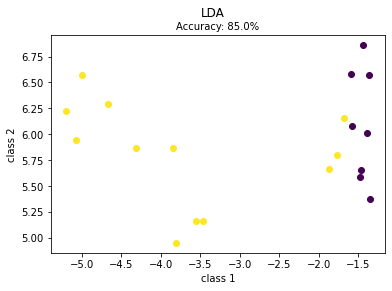

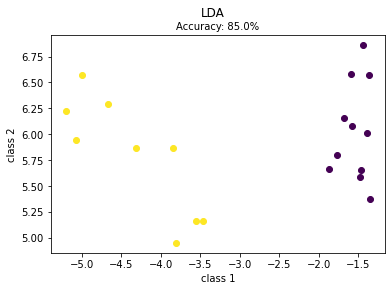

In [32]:
import matplotlib.pyplot as plt

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = LDA().calc_cov(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed

    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('class 1')
        plt.ylabel('class 2')

        plt.show()

Plot().plot_in_2d(X_test, y_pred, title="LDA", accuracy=accuracy)
Plot().plot_in_2d(X_test, y_test, title="LDA", accuracy=accuracy)

### 3 基于sklearn的LDA算法实现

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0
